<a href="https://colab.research.google.com/github/Aleena-Mishra-10/first_01/blob/master/Review_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
import nltk
import math
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from collections import Counter
from matplotlib.colors import ListedColormap
#import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.2.0


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 93% 225M/242M [00:02<00:00, 104MB/s] 
100% 242M/242M [00:02<00:00, 99.8MB/s]


In [72]:
from zipfile import ZipFile
file_name="amazon-fine-food-reviews.zip"

with ZipFile(file_name,'r') as zip_ref:
  zip_ref.extractall()
  print('Done')

Done


In [73]:
reviews = pd.read_csv('Reviews.csv')

In [74]:
print(reviews.shape)

(568454, 10)


In [75]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [76]:
reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [77]:
connection_sqlobject = sqlite3.connect('/content/database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

In [78]:
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


In [79]:
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [80]:
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")


The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


In [81]:
final_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


In [82]:
sampled_dataset = final_data.drop(labels=['Id','ProductId','UserId','ProfileName','Score','HelpfulnessNumerator','HelpfulnessDenominator'],axis=1)

In [83]:
print('Shape of the dataset after dropping unwanted column is:' , sampled_dataset.shape)

Shape of the dataset after dropping unwanted column is: (364171, 5)


In [84]:
sampled_dataset = sampled_dataset.sort_values('Time',axis=0,ascending=False,inplace=False,kind='quicksort',na_position='last')

In [85]:
sampled_dataset=sampled_dataset.reset_index()

In [86]:
sampled_dataset=sampled_dataset.drop(labels=['index'],axis=1)

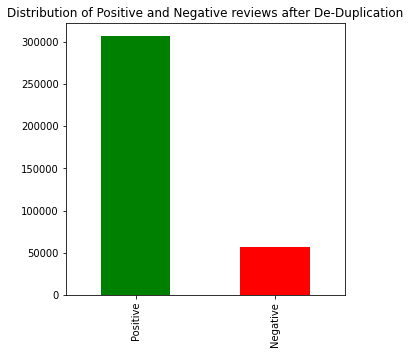

In [87]:
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution of Positive and Negative reviews after De-Duplication',figsize=(5,5))

In [88]:
sampled_dataset.head(10)

,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1351209600,:(,I just got this coffee a few days ago. I had c...,Negative,0
1,1351209600,Wonderful taste!,Very pleased with the quality of the espresso....,Positive,1
2,1351209600,made a great waffle...,Bought this with my new Oster Belgium waffle m...,Positive,1
3,1351209600,bad tasting tea,We drink a lot of tea... from all over the wor...,Negative,0
4,1351209600,Homemade Vanilla Extract,I have always bought my pure vanilla extract i...,Positive,1
5,1351209600,Allergy information from the label: not safe f...,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1
6,1351209600,great soup,"Best soup mix I've tried. I love making soup, ...",Positive,1
7,1351209600,outstanding product,try it & we shared with the familys/all han th...,Positive,1
8,1351209600,Best Microwave popcorn on the market.,If you like butter flavor this is the best mic...,Positive,1
9,1351209600,"Nice tea, not as strong as the stuff from the ...",I love all sorts of teas. My friends know this...,Positive,1


In [89]:
def removeHTML(sentence):
  pattern = re.compile('<.*?>')
  cleaned_text = re.sub(pattern,' ',sentence)
  return cleaned_text

In [90]:
def removePunctuations(sentence):
  cleaned_text = re.sub('[^a-zA-Z]',' ',sentence)
  return cleaned_text

In [91]:
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
sno = SnowballStemmer(language='english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

In [93]:
#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews. 
count = 0
string = ' '
data_corpus = []
all_positive_words = []
all_negative_words = []
stemed_word = ' '


In [94]:
for review in sampled_dataset['Text'].values:
  filtered_sentence = []
  sentence = removeHTML(review)
  for word in sentence.split():
    for cleaned_words in removePunctuations(word).split():
      if((cleaned_words.isalpha())&(len(cleaned_words)>2)):
        if(cleaned_words.lower() not in custom_stopwords):

          stemmed_word=(sno.stem(cleaned_words.lower()))
          filtered_sentence.append(stemmed_word)
          if(sampled_dataset['SentimentPolarity'].values)[count]=='Positive':
            all_positive_words.append(stemed_word)
          if(sampled_dataset['SentimentPolarity'].values)[count]=='Negative':
            all_negative_words.append(stemed_word)
          else:
            continue
        else:
          continue
  string = " ".join(filtered_sentence)
  data_corpus.append(string)
  count+=1
print("The length of the data corpus is : {}".format(len(data_corpus)))

The length of the data corpus is : 364171


In [95]:
#Building a data corpus by removing only the Punctuations and HTML tags. Stopwords are preserved. Words are not stemmed. This is useful for Average Word2Vec, TF-IDF W2V
string = ' '
not_stemmed_corpus = []
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHTML(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha()): #Checking if a word consists of only alphabets    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    string = " ".join(filtered_sentence)    
    not_stemmed_corpus.append(string)


sampled_dataset['CleanedText']=data_corpus

sampled_dataset['PreserveStopwords']=not_stemmed_corpus

In [96]:
print("Printing the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())


Printing the number of positive and negative reviews after data cleaning.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64


In [97]:
#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [98]:
freq_positive=nltk.FreqDist(all_positive_words)
freq_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_positive.most_common(20))
print("Most Common Negative Words : ",freq_negative.most_common(20))

Most Common Positive Words :  [(' ', 11739168)]
Most Common Negative Words :  [(' ', 2394995)]


In [99]:
sampled_dataset.head(20)

,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText,PreserveStopwords
0,1351209600,:(,I just got this coffee a few days ago. I had c...,Negative,0,got coffe day ago coffe bean yesterday today m...,i just got this coffee a few days ago i had co...
1,1351209600,Wonderful taste!,Very pleased with the quality of the espresso....,Positive,1,pleas qualiti espresso pod sturdi enough withs...,very pleased with the quality of the espresso ...
2,1351209600,made a great waffle...,Bought this with my new Oster Belgium waffle m...,Positive,1,bought new oster belgium waffl maker best waff...,bought this with my new oster belgium waffle m...
3,1351209600,bad tasting tea,We drink a lot of tea... from all over the wor...,Negative,0,drink lot tea world far worst tast tea purchas...,we drink a lot of tea from all over the world ...
4,1351209600,Homemade Vanilla Extract,I have always bought my pure vanilla extract i...,Positive,1,alway bought pure vanilla extract mexico got t...,i have always bought my pure vanilla extract i...
5,1351209600,Allergy information from the label: not safe f...,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1,label cadburi screme egg allergi inform manufa...,from the label on the cadbury screme egg aller...
6,1351209600,great soup,"Best soup mix I've tried. I love making soup, ...",Positive,1,best soup mix tri love make soup best tast eas...,best soup mix i ve tried i love making soup an...
7,1351209600,outstanding product,try it & we shared with the familys/all han th...,Positive,1,tri share famili han thumb cut good lite oliv ...,try it we shared with the familys all han thum...
8,1351209600,Best Microwave popcorn on the market.,If you like butter flavor this is the best mic...,Positive,1,like butter flavor best microwav popcorn avail...,if you like butter flavor this is the best mic...
9,1351209600,"Nice tea, not as strong as the stuff from the ...",I love all sorts of teas. My friends know this...,Positive,1,love sort tea friend know travel often bring t...,i love all sorts of teas my friends know this ...


In [100]:
def standardize(x_train_vector,x_test_vector):
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=False)
    scalar.fit(x_train_vector)
    scalar.fit(x_test_vector)
    x_train_vectors = scalar.transform(x_train_vector)
    x_test_vectors = scalar.transform(x_test_vector)

    print("Shape of the x_train_vectors is: {}".format(x_train_vectors.shape))
    print("Shape of the x_test_vectors is : {}".format(x_test_vectors.shape))

    return(x_train_vectors,x_test_vectors)

In [101]:
def top_features(nb_classifier,vectorizer_object):
    neg_class_prob_sorted = (-nb_classifier.feature_log_prob_[0,:]).argsort()
    pos_class_prob_sorted = (-nb_classifier.feature_log_prob_[1,:]).argsort()
    neg_class_features = np.take(vectorizer_object.get_feature_names(),neg_class_prob_sorted[:50])
    pos_class_features = np.take(vectorizer_object.get_feature_names(),pos_class_prob_sorted[:50])
    print("The top 50 most frequent words from the positive class are:\n")
    print(pos_class_features)
    print("The top 50 most frequent words from the negetive class are:\n")
    print(neg_class_features)

    del(neg_class_prob_sorted,pos_class_prob_sorted,neg_class_features,pos_class_features)

In [102]:
def performance(nb_classifier,vectorizationType,x_train,y_train,x_test,y_test,optimal_alpha,mse):
    print("\n'''PERFORMANCE EVALUATION'''")
    print("\n\nDetailed report for the {} Vectorization.".format(vectorizationType))
    y_pred = nb_classifier(x_test)
    test_accuracy = accuracy_score(y_test,y_pred,normalize=True)*100
    points = accuracy_score(y_test,y_pred,normalize=False)
    print('\nThe number of accurate predictions out of {} data points on unseen data is {}'.format(X_test.shape[0], points))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, np.round(test_accuracy,2)))


    print("Precision of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.precision_score(y_test ,y_pred),4)))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.recall_score(y_test ,y_pred),4)))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.f1_score(y_test ,y_pred),4)))

    print ('\nClasification report for {} model : \n'.format(vectorizationType))
    print(metrics.classification_report(y_test,y_pred))

    #Print the Conclusions on the trained dataset
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp+fn #p = total number of actual postives
    n = fp+tn #p = total number of actual negatives
    TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
    print("\nThe True Positives Rate is : {}".format(TPR))
    print("The True Negatives Rate is : {}".format(TNR))
    print("The False Positives Rate is : {}".format(FPR))
    print("The False Negatives Rate is : {}".format(FNR))

    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))


    #Save the below list for later use to display model information
    info_model_NB = [vectorizationType, optimal_alpha, np.round(np.array(mse).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4), points]
    with open('info_model_NB.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_NB)
        filehandle.writelines("\n")


    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix for {} model.".format(vectorizationType))
    sciplot.plot_confusion_matrix(y_test ,y_pred)


    #Free memory allocations
    del(X_train, y_train, X_test, y_test, vectorizationType, y_pred, nb_classifier)



In [103]:
def get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    alphas = np.logspace(-5, 4, 100)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds)
    model = MultinomialNB()
    my_cv = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=my_cv, scoring='f1', n_jobs=6)
    gsearch_cv.fit(X_train, y_train)
    print("\nGridSearchCV completed for {} model!".format(vectorizationType))
    print("Best estimator for {} model : ".format(vectorizationType), gsearch_cv.best_estimator_)
    print("Best Score for {} model : ".format(vectorizationType), gsearch_cv.best_score_)
    return gsearch_cv

In [104]:
def plot_errors(gsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values'''
    #Get cross validation scores. Here we obtain the alpha values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    mts = cv_result["mean_test_score"]        #list that will hold the mean of cross validation accuracy scores for each alpha
    alphas = cv_result["params"]

    alpha_values = []                         #list that will hold all the alpha values that the grid search cross validator tried.
    for i in range(0,len(alphas)):
        alpha_values.append(alphas[i]["alpha"])

    #Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    mse = [1 - x for x in mts]

    #Determining best alpha from errors. 'alpha' will be best for the lowest value for error
    optimal_alpha = alpha_values[mse.index(min(mse))] #Laplace smoothing
    print('The optimal value of alpha is : {}'.format(optimal_alpha))     

    #Plot error vs alpha values
    plt.figure(figsize=(35,8))
    plt.plot(alpha_values , mse, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    for xy in zip(alpha_values, np.round(mse,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Plot for Errors vs Alpha Values')
    plt.xlabel('Values of Alpha')
    plt.ylabel('Errors')
    plt.show()
    
    return (optimal_alpha,mse)

In [105]:
def naive_bayes_algorithm(X_train, y_train, X_test, y_test, vectorizationType, vectorizer_object):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A time series 10 fold cross validation is performed on the train data and the value of optimal alpha is calculated. 
    The dataset is then trained with this value of optimal alpha. 
    Finally the Naive Bayes model is used to predict its accuracy on the future unseen test set.'''
    
    #Perform 10-fold cross validation on the train set
    print("Starting Cross Validation steps...")
    gsearch_cv = get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test)
    
    #Plot the graphical representation of the mean squared error vs the alpha values obtained during cross validation.
    optimal_alpha, mse = plot_errors(gsearch_cv)

    #Initialize the Naive Bayes constructor using alpha = optimal_alpha
    nb_classifier = gsearch_cv.best_estimator_
    #Fit the model to the train set using optimal alpha
    nb_classifier.fit(X_train, y_train)
    
    #Display the top features of both the negative and positive reviews
    top_features(nb_classifier, vectorizer_object)
    
    #Evaluate the model's performance
    performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse)


Creating the BOW vectors using the cleaned corpus
Shape of the x_train_vectors is: (291336, 64001)
Shape of the x_test_vectors is : (72835, 64001)
Starting Cross Validation steps...

GridSearchCV completed for Bag-of-Words model!
Best estimator for Bag-of-Words model :  MultinomialNB(alpha=284.8035868435805, class_prior=None, fit_prior=True)
Best Score for Bag-of-Words model :  0.9125322935121799
The optimal value of alpha is : 284.8035868435805


TypeError: ignored

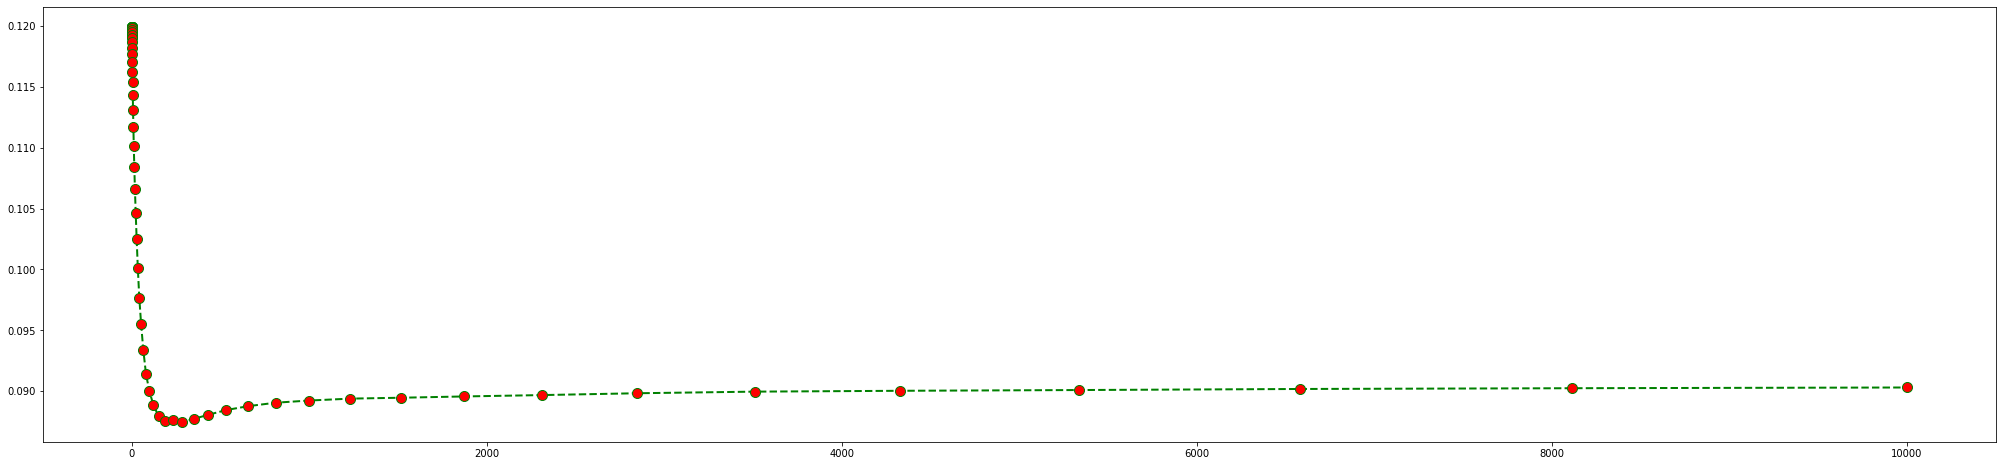

In [106]:
'''Creating the Bag of Words vector for the cleaned reviews.'''
#Bag of Words model creation using cleaned text 

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations. 
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words", cv_object)

In [107]:
'''Tri-Grams model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.
This model won't contain single words. This will mostly try to figure out the relationships between consecutive words in a sentences '''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)
#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tri_grams_object = TfidfVectorizer(ngram_range=(2,3)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = tri_grams_object.transform(X_train)
X_test_vectors = tri_grams_object.transform(X_test)
#Colum Standardization of the tri-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Tri-Grams", tri_grams_object)


Creating the BOW vectors using PreserveStopwords corpus
Shape of the x_train_vectors is: (291336, 11580701)
Shape of the x_test_vectors is : (72835, 11580701)
Starting Cross Validation steps...


exception calling callback for <Future at 0x7f0b2eff2cc0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/joblib/_parallel_backends.py", line 529, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/usr/local/lib/

TerminatedWorkerError: ignored